# Problem Statement

#### ● The goal is to predict Tesla stock prices using historical data.
#### ● We will use a deep learning-based approach (SimpleRNN and LSTM) to
#### model stock price trends.
#### ● The dataset consists of features: Date, Open, High, Low, Close, Adj Close,
#### and Volume.


# Importing neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV


# Data Understanding

In [2]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,29-06-2010,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,30-06-2010,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,01-07-2010,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,02-07-2010,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,06-07-2010,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [4]:
df['Date'].unique()

array(['29-06-2010', '30-06-2010', '01-07-2010', ..., '30-01-2020',
       '31-01-2020', '03-02-2020'], shape=(2416,), dtype=object)

In [5]:
df['Open'].unique()

array([ 19.      ,  25.790001,  25.      , ..., 632.419983, 640.      ,
       673.690002], shape=(2132,))

In [6]:
df['High'].unique()

array([ 25.      ,  30.42    ,  25.92    , ..., 650.880005, 653.      ,
       786.140015], shape=(2128,))

In [7]:
df['Low'].unique()

array([ 17.540001,  23.299999,  20.27    , ..., 618.      , 632.52002 ,
       673.52002 ], shape=(2136,))

In [8]:
df['Close'].unique()

array([ 23.889999,  23.83    ,  21.959999, ..., 640.809998, 650.570007,
       780.      ], shape=(2225,))

In [9]:
df['Adj Close'].unique()

array([ 23.889999,  23.83    ,  21.959999, ..., 640.809998, 650.570007,
       780.      ], shape=(2225,))

In [10]:
df['Volume'].unique()

array([18766300, 17187100,  8218800, ..., 29005700, 15719300, 47065000],
      shape=(2391,))

In [11]:
#Checking for duplicate rows
df.duplicated().sum()

np.int64(0)

In [12]:
#Checking for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


C:\Users\golla\AppData\Local\Temp\ipykernel_11540\1756150960.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


#### We convert the Date column to a datetime format so that the model and analysis tools correctly understand the temporal order, time intervals, and trends in stock price data.

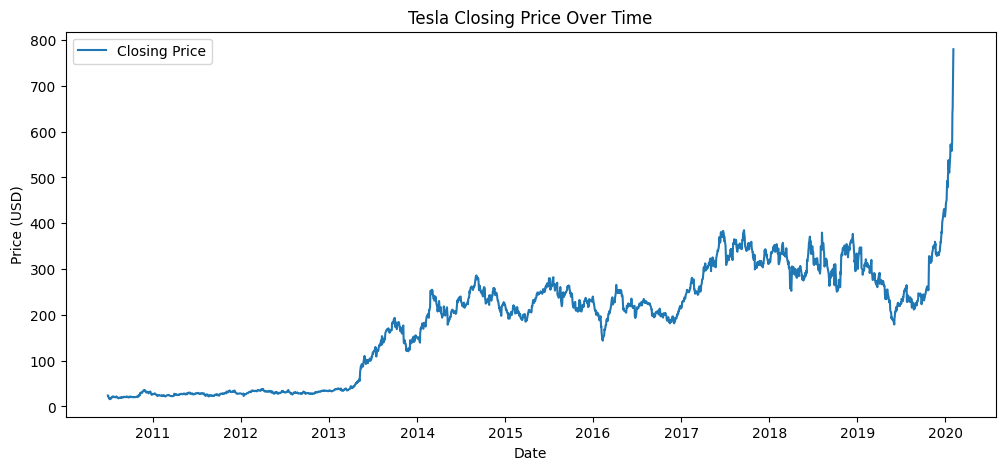

In [14]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Closing Price')
plt.title("Tesla Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


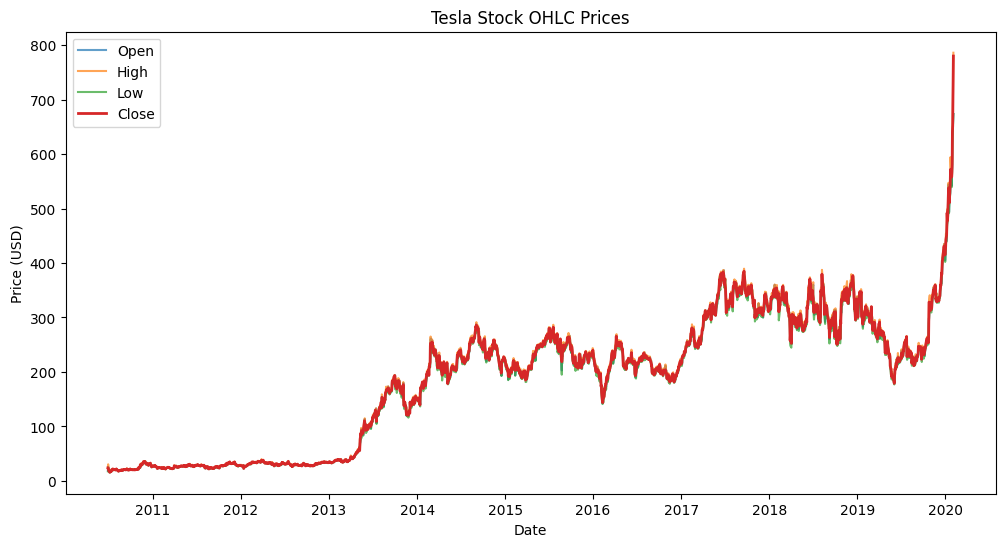

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df['Open'], label='Open', alpha=0.7)
plt.plot(df['High'], label='High', alpha=0.7)
plt.plot(df['Low'], label='Low', alpha=0.7)
plt.plot(df['Close'], label='Close', linewidth=2)
plt.title("Tesla Stock OHLC Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


#### Close price trend reflects long-term investor sentiment

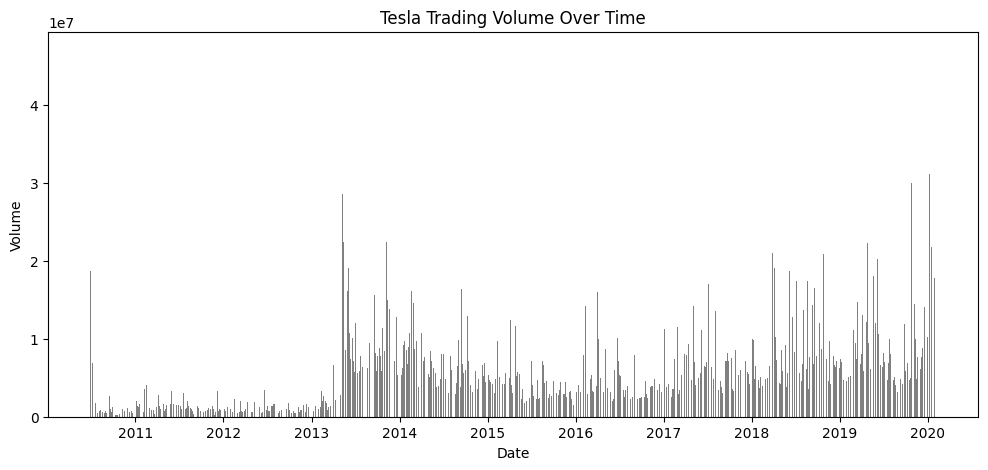

In [16]:
plt.figure(figsize=(12,5))
plt.bar(df.index, df['Volume'], color='grey')
plt.title("Tesla Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()


#### Volume shows market participation
#### Sudden spikes indicate news, earnings, or events

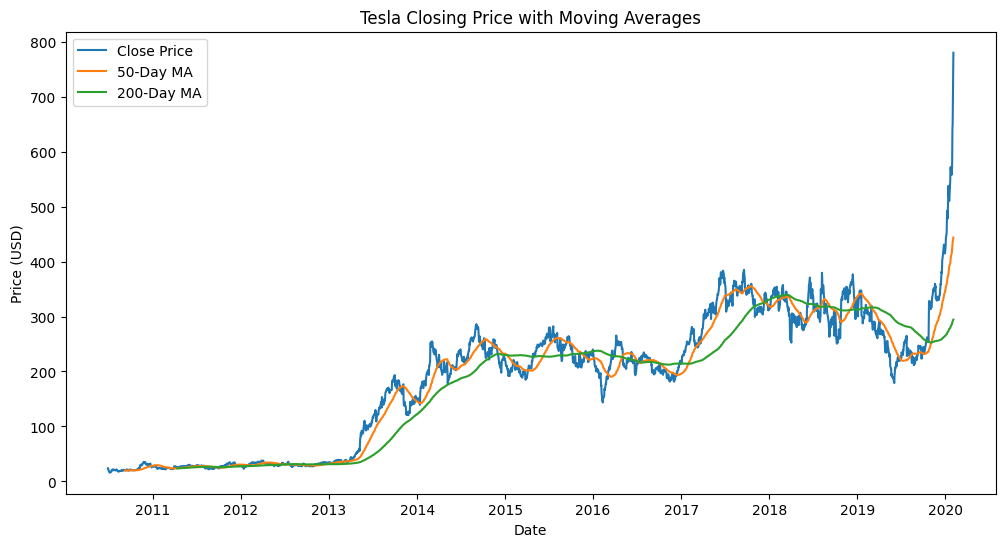

In [17]:
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_50'], label='50-Day MA')
plt.plot(df['MA_200'], label='200-Day MA')
plt.title("Tesla Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


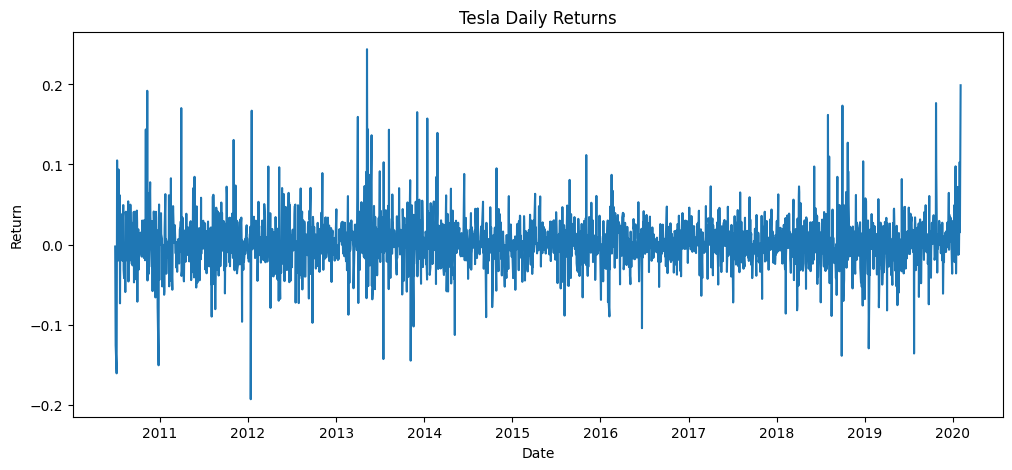

In [18]:
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(12,5))
plt.plot(df['Daily_Return'])
plt.title("Tesla Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()


#### Sudden spikes → market shocks
#### Helps identify unstable periods

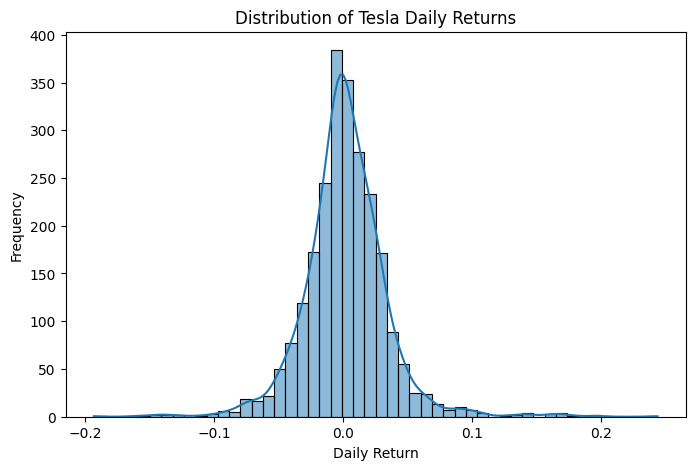

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(df['Daily_Return'].dropna(), bins=50, kde=True)
plt.title("Distribution of Tesla Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


#### Shows whether returns are normally distributed
#### Important for financial risk modeling

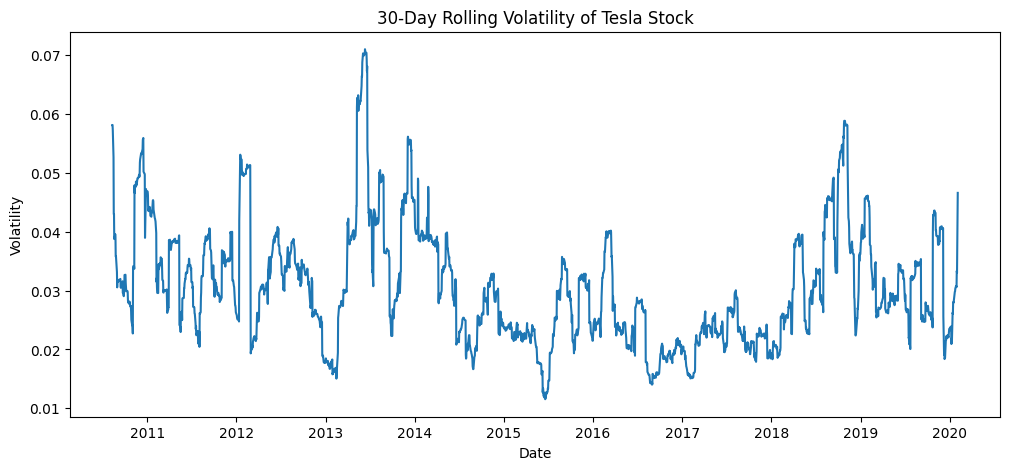

In [20]:
df['Volatility'] = df['Daily_Return'].rolling(window=30).std()

plt.figure(figsize=(12,5))
plt.plot(df['Volatility'])
plt.title("30-Day Rolling Volatility of Tesla Stock")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


#### High volatility → unstable market
#### Low volatility → consolidation phase

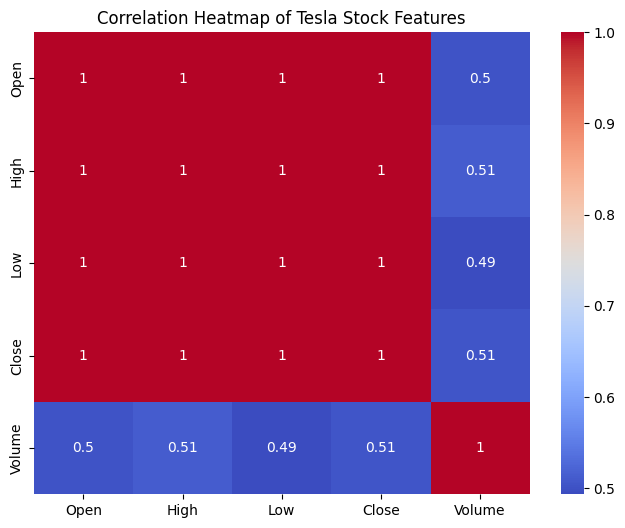

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Tesla Stock Features")
plt.show()


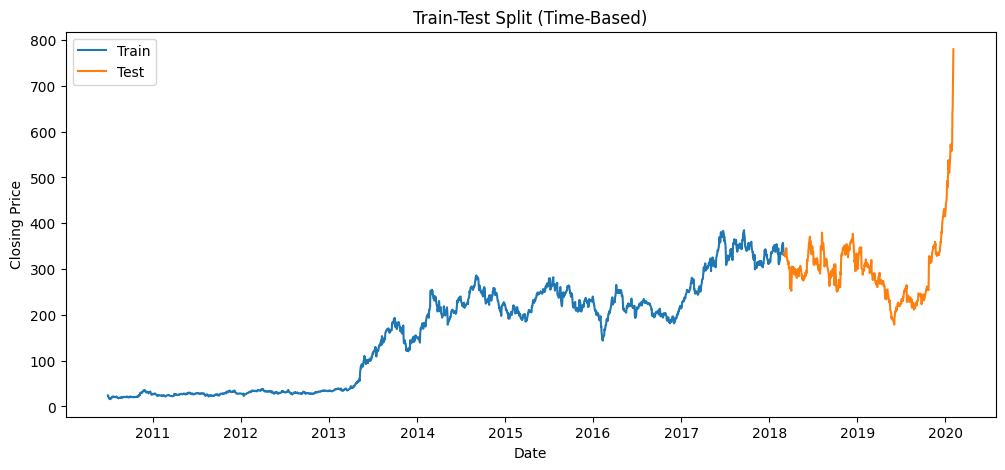

In [22]:
train_size = int(len(df) * 0.8)

plt.figure(figsize=(12,5))
plt.plot(df.index[:train_size], df['Close'][:train_size], label='Train')
plt.plot(df.index[train_size:], df['Close'][train_size:], label='Test')
plt.title("Train-Test Split (Time-Based)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


In [24]:
df

,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200,Daily_Return,Volatility
Date,,,,,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300,NaN,NaN,NaN,NaN
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,NaN,NaN,-0.002511,NaN
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,NaN,NaN,-0.078473,NaN
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,NaN,NaN,-0.125683,NaN
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,NaN,NaN,-0.160937,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500,418.773402,286.456801,0.015913,0.030752
2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500,423.406202,288.023250,0.024854,0.030574
2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700,429.179001,289.895400,0.102962,0.033331


In [25]:
data = df[['Adj Close']]
data.head()


,Adj Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


#### It accounts for stock splits, dividends, and corporate actions — making it more reliable for prediction.

# Min-Max Scaling

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data[:5]

array([[0.01058623],
       [0.01050772],
       [0.00806072],
       [0.0044491 ],
       [0.00040565]])

# Creating Time-Series Sequences

In [29]:
def create_sequences(data, window_size):
    X = []
    y = []
    
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
        
    return np.array(X), np.array(y)
WINDOW_SIZE = 60   # using past 60 days
X, y = create_sequences(scaled_data, WINDOW_SIZE)


In [30]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2356, 60)
y shape: (2356,)


In [31]:
X = X.reshape(X.shape[0], X.shape[1], 1)


# Splitting

In [32]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
simple_rnn_model = Sequential()

# SimpleRNN layer
simple_rnn_model.add(
    SimpleRNN(
        units=50,
        activation='tanh',
        input_shape=(X_train.shape[1], 1)
    )
)

# Dropout layer
simple_rnn_model.add(Dropout(0.2))

# Output layer
simple_rnn_model.add(Dense(1))
simple_rnn_model.summary()




c:\Users\golla\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
lstm_model = Sequential()

# First LSTM layer
lstm_model.add(
    LSTM(
        units=50,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    )
)

# Dropout layer
lstm_model.add(Dropout(0.2))

# Second LSTM layer
lstm_model.add(
    LSTM(
        units=50,
        return_sequences=False
    )
)

# Dropout layer
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the models

## RNN Model

In [35]:
from tensorflow.keras.optimizers import Adam

simple_rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)


# LSTM Model

In [36]:
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)


# Training Model

In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

rnn_checkpoint = ModelCheckpoint(
    'simple_rnn_best.h5',
    monitor='val_loss',
    save_best_only=True
)

lstm_checkpoint = ModelCheckpoint(
    'lstm_best.h5',
    monitor='val_loss',
    save_best_only=True
)


# Simple RNN Model Training

In [39]:
history_rnn = simple_rnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, rnn_checkpoint],
    verbose=1
)


Epoch 1/30


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1610e-04 - val_loss: 4.7597e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2956e-04 - val_loss: 7.9970e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3203e-04 - val_loss: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3611e-04 - val_loss: 5.5770e-04
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7828e-04 - val_loss: 7.2853e-04


# Training LSTM Model

In [40]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, lstm_checkpoint],
    verbose=1
)


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0111

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0042 - val_loss: 5.3680e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 6.5294e-04 - val_loss: 0.0015
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.2514e-04

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.6981e-04 - val_loss: 5.2850e-04
Epoch 4/30
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.5408e-04

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 5.7124e-04 - val_loss: 4.8179e-04
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.0612e-04

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.1925e-04 - val_loss: 4.1281e-04
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.6556e-04 - val_loss: 4.1515e-04
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 4.9425e-04 - val_loss: 4.7368e-04
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.5618e-04 - val_loss: 4.7177e-04
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.3150e-04 - val_loss: 0.0013
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 4.6495e-04 - val_loss: 4.8377e-04


# Prediction On Test Data

In [41]:
rnn_predictions = simple_rnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [42]:
from sklearn.metrics import mean_squared_error

rnn_mse = mean_squared_error(y_test_actual, rnn_predictions)
lstm_mse = mean_squared_error(y_test_actual, lstm_predictions)

print("SimpleRNN MSE:", rnn_mse)
print("LSTM MSE:", lstm_mse)


SimpleRNN MSE: 730.8090414469668
LSTM MSE: 765.4998941885327


In [43]:
import numpy as np

rnn_rmse = np.sqrt(rnn_mse)
lstm_rmse = np.sqrt(lstm_mse)

print("SimpleRNN RMSE:", rnn_rmse)
print("LSTM RMSE:", lstm_rmse)


SimpleRNN RMSE: 27.033480009924116
LSTM RMSE: 27.66766875232774


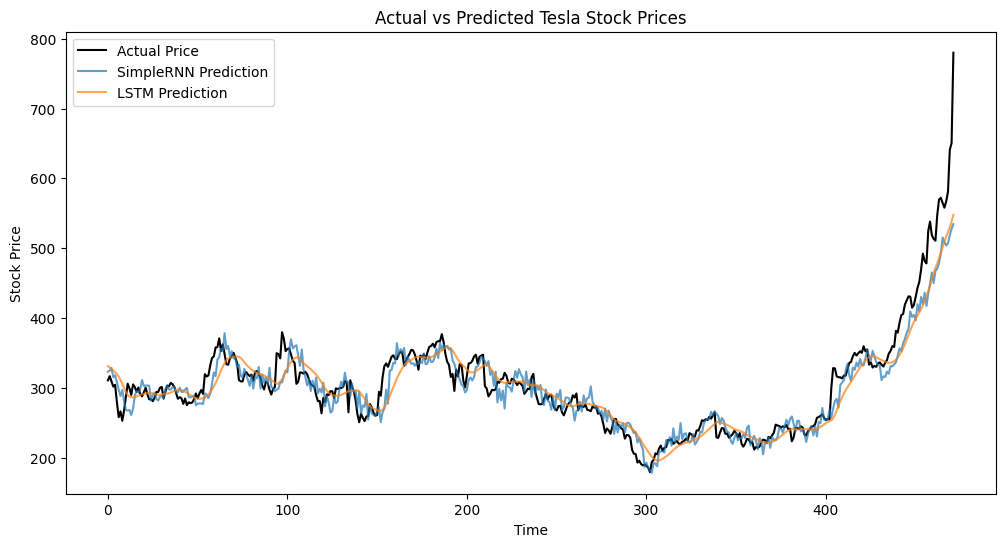

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price', color='black')
plt.plot(rnn_predictions, label='SimpleRNN Prediction', alpha=0.7)
plt.plot(lstm_predictions, label='LSTM Prediction', alpha=0.7)
plt.title("Actual vs Predicted Tesla Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
